In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal
from torch.utils.data import DataLoader
import numpy as np

In [7]:
prev_timesteps = 3
prediction_steps = 1
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, prev_timesteps=prev_timesteps, max_future_time_steps=prediction_steps)
test = MoviaBusDataset('../data/test', interpolation=True, prev_timesteps=prev_timesteps, max_future_time_steps=prediction_steps)

train.normalize()
test.normalize(train.mean, train.std)


In [21]:
train_DL = DataLoader(train, batch_size=batch_size, shuffle=False)
test_DL = DataLoader(test, batch_size=len(test), shuffle=False)

In [22]:
#i , batch in enumerate(train_DL)
#batch['data'][:,-1,:]

In [23]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[0]

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
    
        self.lstm = nn.LSTM(num_roads, num_roads, batch_first=True, num_layers=1)
        #self.lstm = nn.LSTM(num_roads, num_roads, batch_first=True, num_layers=2,dropout=0.2)
        self.activation = nn.ReLU()
        
    # self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        n_batch = x.size()[0]
        hidden = (torch.randn(2, n_batch, num_roads),
                  torch.randn(2, n_batch, num_roads))
        #for t_i in range(num_timesteps):
        #    out, hidden = self.lstm(x[:,t_i,:].view(-1,1,num_roads),hidden)
        
        
        #x : [batch_size, timesteps, wayids]   
        out, hidden = self.lstm(x, hidden)
        
        prediction = out[:,-1,:]
        for i in range(prediction_steps-1):
            prediction, hidden = self.lstm(prediction.view(-1,1,num_roads),hidden)
      
        
        prediction = out[:,-1,:]
        for i in range(predtiction_steps-1)
            prediction, hidden = self.lstm(prediction.view(-1,1,num_roads),hidden)
        
        return prediction

net = RNN()

optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.L1Loss()

In [24]:
net.train()
for epoch in range(80):
    cur_loss = []
    for i , batch in enumerate(train_DL):
        output = net(batch['data'][:,:,:-1]).squeeze()
        target = batch['target']

        optimizer.zero_grad()
        
        loss = criterion(output, target)   
        loss.backward()
        
        optimizer.step()
  
        cur_loss.append(loss.item())
    
    if epoch % 5 == 0:
        print("epoch = %2i  loss = %0.3f  output_std = %0.3f" %(epoch, np.mean(cur_loss), output.std().item()))

epoch =  0  loss = 0.756  output_std = 0.150
epoch =  5  loss = 0.690  output_std = 0.236
epoch = 10  loss = 0.651  output_std = 0.276
epoch = 15  loss = 0.615  output_std = 0.323
epoch = 20  loss = 0.583  output_std = 0.361
epoch = 25  loss = 0.554  output_std = 0.394
epoch = 30  loss = 0.529  output_std = 0.421
epoch = 35  loss = 0.507  output_std = 0.442
epoch = 40  loss = 0.488  output_std = 0.460
epoch = 45  loss = 0.472  output_std = 0.474
epoch = 50  loss = 0.458  output_std = 0.484
epoch = 55  loss = 0.445  output_std = 0.493
epoch = 60  loss = 0.434  output_std = 0.502
epoch = 65  loss = 0.423  output_std = 0.508
epoch = 70  loss = 0.415  output_std = 0.515
epoch = 75  loss = 0.407  output_std = 0.523


In [25]:
net.eval()
for i, batch in enumerate(test_DL):
    
    output = net(batch['data'][:,:,:-1]).squeeze()
    target = batch['target']
        
    output = output*torch.tensor(train.std) + torch.tensor(train.mean)
    target = target*torch.tensor(train.std) + torch.tensor(train.mean)
    
    loss = criterion(output,target)
    print(loss.item())

1.6620540618896484


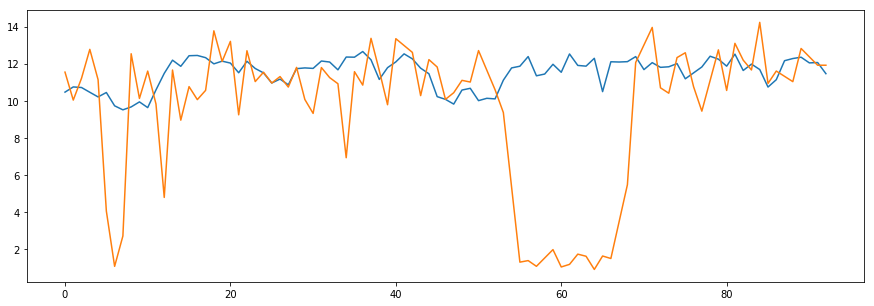

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(output[:,23].detach().numpy())
plt.plot(target[:,23].detach().numpy())